In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from IPython.display import display

### Gibbs free energy of mixing (regular solution)
$$
\Delta G_{\text{mix, regular}} = \Delta H_{\text{mix, regular}} - T \Delta S_{\text{mix, regular}}
$$

### Enthalpy of mixing (regular solution)
$$
\Delta H_{\text{mix, regular}} = \Omega x_A x_B
$$

### Interaction parameter
$$
\Omega = N_A z \varepsilon
$$

### Bond interaction energy
$$
\varepsilon = E_{A-B} - \frac{1}{2}\left(E_{A-A} + E_{B-B}\right)
$$

### Gibbs free energy of mixing (regular solution)

$$
\Delta G_{\text{mix, regular}} = \Omega x_A x_B - T \Delta S_{\text{mix, regular}}
$$

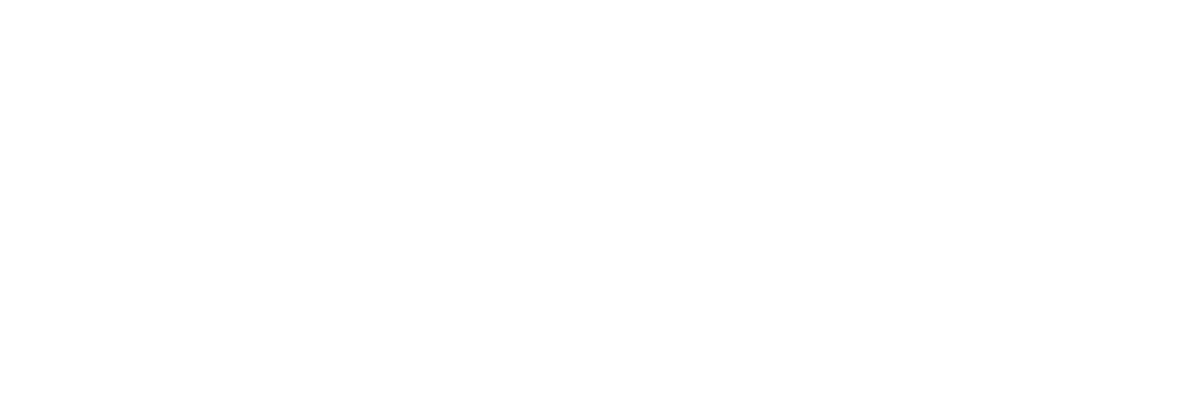

interactive(children=(FloatSlider(value=200.0, description='T', max=400.0, min=1.0, step=0.5), FloatSlider(val…

<function __main__.update(T=200, Omega=4000)>

In [8]:
R = 8.314

# free energy
def G(x, T, Omega):
    x = np.clip(x, 1e-8, 1-1e-8)
    return R*T*(x*np.log(x) + (1-x)*np.log(1-x)) + Omega*x*(1-x)

# numerical second derivative
def second_derivative(y, x):
    return np.gradient(np.gradient(y, x), x)

# composition grid
x = np.linspace(0.001, 0.999, 800)

# storage for phase diagram
T_points = []
x_left = []
x_right = []
last_Omega = None   # track Ω changes

# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# --- left: free energy
line_G, = ax1.plot(x, G(x, 200, 4000))
min_points, = ax1.plot([], [], 'ko', ms=6)

ax1.set_xlabel("Composition x")
ax1.set_ylabel("Gibbs Free Energy")
ax1.set_title("Free Energy G(x)")

# temperature display
temp_text = ax1.text(
    0.02, 0.95, "",
    transform=ax1.transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
)

# --- right: phase diagram
ax2.set_xlabel("Composition x")
ax2.set_ylabel("Temperature (K)")
ax2.set_title("Emerging Phase Diagram")

phase_left, = ax2.plot([], [], 'ko', ms=4)
phase_right, = ax2.plot([], [], 'ko', ms=4)

ax2.set_ylim(0, 500)  # fixed nicer range
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

# --- update function
def update(T=200, Omega=4000):
    global T_points, x_left, x_right, last_Omega
    
    # reset diagram if Ω changed
    if last_Omega is None:
        last_Omega = Omega
    if Omega != last_Omega:
        T_points.clear()
        x_left.clear()
        x_right.clear()
        phase_left.set_data([], [])
        phase_right.set_data([], [])
        last_Omega = Omega

    g = G(x, T, Omega)
    line_G.set_ydata(g)

    # info box
    if Omega > 0:
        Tc = Omega/(2*R)
        temp_text.set_text(f"T = {T:.1f} K\nΩ = {Omega:.0f} J/mol\nTc = {Tc:.1f} K")
    else:
        temp_text.set_text(f"T = {T:.1f} K\nΩ = {Omega:.0f} J/mol")

    # find minima
    d2 = second_derivative(g, x)
    minima_indices = np.where(
        (np.roll(d2,1) > 0) & 
        (d2 > 0) & 
        (g < np.roll(g,1)) & 
        (g < np.roll(g,-1))
    )[0]

    minima_indices = minima_indices[(minima_indices > 5) & (minima_indices < len(x)-5)]

    if len(minima_indices) >= 2:
        x1 = x[minima_indices[0]]
        x2 = x[minima_indices[-1]]

        min_points.set_data([x1, x2], [G(x1,T,Omega), G(x2,T,Omega)])

        T_points.append(T)
        x_left.append(x1)
        x_right.append(x2)

        phase_left.set_data(x_left, T_points)
        phase_right.set_data(x_right, T_points)
    else:
        min_points.set_data([], [])

    ax1.relim()
    ax1.autoscale_view()

    # keep phase diagram readable
    ax2.set_ylim(0, 500)
    ax2.set_xlim(0, 1)

    fig.canvas.draw_idle()

# sliders
interact(
    update,
    T=FloatSlider(min=1, max=400, step=0.5, value=200),
    Omega=FloatSlider(min=-4000, max=4000, step=200, value=4000)
)